In [1]:
# Import libraries
import os
#libreria para trabajar con el sistema
import os.path as op
#combinar rutas. El "as" cambia el nombre al que nosotros elijamos para hacerlo más intuitivo
import numpy as np
#calculo numerica
import nibabel as nib
#libreria para trabajar con imagenes neurologicas
import matplotlib.pyplot as plt
#representacion en python
from dipy.data import fetch_sherbrooke_3shell
fetch_sherbrooke_3shell()
from os.path import expanduser, join
home = expanduser('~')


In [12]:
import numpy
from scipy.ndimage.morphology import binary_fill_holes, binary_dilation,\
    binary_erosion

In [2]:
# Load input image
img = nib.load(op.join(os.getcwd(), 'inputs', 'ADC.nii.gz'))
#img = nib.load(op.join(os.getcwd(), 'inputs', 'IXI_519_DTI.nii.gz'))
#tienen que tener extension .nii o .gz
data = img.get_fdata()
print("Image shape:", data.shape)
print("Voxels size:", img.header.get_zooms())

Image shape: (256, 256, 18)
Voxels size: (1.09375, 1.09375, 6.999999)


In [3]:
# Select image slice for visualization
# Coronal
slice_cor = data[:][84][:]
slice_cor = np.rot90(slice_cor)
# Axial
slice_axi = data[:][:][42]
slice_axi = np.rot90(slice_axi)


Text(0.5, 1.0, 'Axial slice')

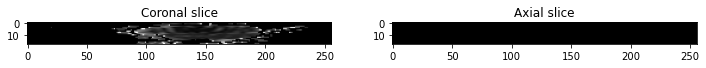

In [4]:
# Plot slices 
plt.figure(figsize=(12, 10))
plt.subplot(121)
plt.imshow(slice_cor, cmap='gray')
plt.title('Coronal slice')
plt.subplot(122)
plt.imshow(slice_axi, cmap='gray')
plt.title('Axial slice')
# plt.axis('off')

In [5]:
#CÓDIGO CON LOS VALORES/VECTORES DE B

# dname contiene el nombre del directorio que contiene los 3 archivos.
dname = join(home, '.dipy', 'sherbrooke_3shell')
fdwi = join(dname, 'HARDI193.nii.gz')
fbval = join(dname, 'HARDI193.bval')
fbvec = join(dname, 'HARDI193.bvec')

from dipy.io.image import load_nifti #Para cargar datos de un archivo nifti
data, affine, img = load_nifti(fdwi, return_img=True) #carga los datos de difusion almacenados en fdwi.
#print(data.shape) SI QUEREMOS SABER LA DIMESION DE LA IMAGEN Y EL NUMERO DE GRADIENTES TOMADOS EN TOTAL

In [6]:
# Se cargan los valores de b y vectores de b. Se utiliza la función de DIPY read_bvals_bvecs.
from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

In [7]:
#El objeto gradient_table contiene todos los parámetros de la adquisición.from dipy.core.gradients import gradient_table
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

In [89]:
#se utiliza Matplotlib para visualizar resulados.
#A continuación se muestran los cortes axiales medios de volumen 0 (b0) y volumen 10
import matplotlib.pyplot as plt
axial_middle = data.shape[2] // 2# loading input images

S0 = data[:, :, axial_middle, 0].T
#b0img, b0hdr = data[:, :, axial_middle, 0]
S1 = data[:, :, axial_middle, 10].T
b = bvals[10]
   
# convert to float
S0 = S0.astype(numpy.float)
S1 = bximg.astype(numpy.float)

Text(0.5, 1.0, 'DWI para b=1000')

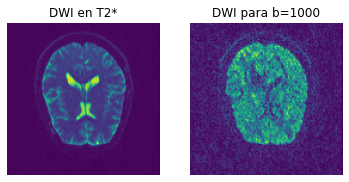

In [90]:
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(S0)
plt.title('DWI en T2*')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(S1)
plt.title('DWI para b=%d' %b)

Text(0.5, 1.0, 'MAPA ADC para b=1000')

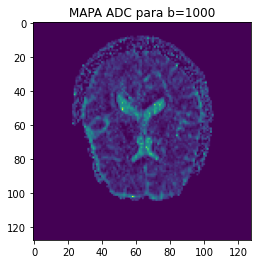

In [94]:
#CÓDIGO PARA CALCULAR EL MAPA ADC
    # threshold b0 + bx DWI to obtain a mask
    # b0 mask avoid division through 0, bx mask avoids a zero in the ln(x) computation
import argparse
import logging
import numpy

from medpy.core import Logger
from medpy.io import load, save, header
from medpy.filter import otsu
from medpy.core.exceptions import ArgumentError
from medpy.filter.binary import largest_connected_component

#b0thr = bxthr = 1
#the default threshold is chosen using Otsu's. [TU Hamburg code]
b0thr = otsu(S0, 32) / 4. # divide by 4 to decrease impact
bxthr = otsu(S1, 32) / 4.

# threshold b0 + bx DWI to obtain a mask
# b0 mask avoid division through 0, bx mask avoids a zero in the ln(x) computation
mask = binary_fill_holes(S0 > b0thr) & binary_fill_holes(S1 > bxthr)
    
# perform a number of binary morphology steps to select the brain only
mask = binary_erosion(mask, iterations=1)
mask = largest_connected_component(mask)
mask = binary_dilation(mask, iterations=1)
    
#compute the ADC map
adc = numpy.zeros(S0.shape, S0.dtype)
#adc[mask] = -1. * b * numpy.log(S1[mask] / S0[mask])
#Ecuacion para obtener el valor de ADC indicado en el punto 4 del documento word compartido
# en el modelo IVIM para promediar el gradiente en cada vóxel.
adc[mask]= (-1./b)*np.log(S1[mask] / S0[mask])
adc[adc < 0] = 0

plt.imshow(adc)
plt.title('MAPA ADC para b=%d' %b)
# saving the resulting image
#save(adc, args.output, bvals[0], args.force)